In [23]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np
import math
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

def startup():
    all_unis = {}
    all_completions = {}
    unis = pd.read_csv('../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    for year in range(2010, 2022):
        all_unis[year] = unis
        all_completions[year] = pd.read_csv('../data/IPEDS/completions/c%s_a.csv' % year)
        all_unis[year].set_index('UNITID')
        all_completions[year].set_index('UNITID')
    demo_names = ['CTOTALW', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, demo_names

In [3]:
def make_years(completions, unis, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = unis[year], completions[year]
        years[year] = [year_completions, year_unis]
    return years

In [4]:
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        unis, data = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge.set_index('UNITID')
        nonCsMerge.set_index('UNITID')
        csMerge['year'] = year
        nonCsMerge['year'] = year
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    data = data.reset_index()
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [5]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year'])
    nonCs = nonCs.set_index(['UNITID', 'year'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [6]:
def grouped(cs, nonCs):
    cs = cs.groupby('year').sum()
    nonCs = nonCs.groupby('year').sum()
    return cs.reset_index(), nonCs.reset_index()

In [7]:
all_unis, all_completions, demo_names = startup()

In [8]:
years = make_years(all_completions, all_unis, 2011, 2021)

In [9]:
csTotal, nonCsTotal = groupTotals(years)

In [10]:
csTotalGroup, nonCsTotalGroup = grouped(csTotal, nonCsTotal)
#csPercentGroup, nonCsPercentGroup = grouped(csPercent, nonCsPercent)

In [11]:
csPercent, nonCsPercent = make_percents(csTotalGroup, nonCsTotalGroup)

In [12]:
minorityTotal = csTotal['CTOTALW'] + csTotal['CBKAAT'] + csTotal['CHISPT']

In [13]:
csTotal['minority'] = 0
nonCsTotal['minority'] = 0

In [14]:
csTotal['minority'] = csTotal['CTOTALW'] + csTotal['CBKAAT'] + csTotal['CHISPT']
nonCsTotal['minority'] = nonCsTotal['CTOTALW'] + nonCsTotal['CBKAAT'] + nonCsTotal['CHISPT']

In [15]:
csTotal = csTotal.groupby('year').sum()
nonCsTotal = nonCsTotal.groupby('year').sum()

In [16]:
csTotal = csTotal.reset_index()
nonCsTotal = nonCsTotal.reset_index()

In [17]:
csPercent['minority'] = csTotal['minority']
nonCsPercent['minority'] = nonCsTotal['minority']

In [18]:
csPercent['minority'] = csPercent['minority']/csTotal['CTOTALT']
nonCsPercent['minority'] = nonCsPercent['minority']/nonCsTotal['CTOTALT']

In [19]:
csPercent, nonCsPercent

(       UNITID  year   CTOTALW    CAIANT    CBKAAT    CHISPT  CTOTALT  minority
 0   774870122  2011  0.235144  0.006916  0.123550  0.090943      1.0  0.449636
 1   767445081  2012  0.229128  0.006955  0.115450  0.093867      1.0  0.438445
 2   765012618  2013  0.225480  0.006582  0.120724  0.099833      1.0  0.446037
 3   763251241  2014  0.227871  0.006623  0.119012  0.101368      1.0  0.448251
 4   756361081  2015  0.232618  0.005891  0.112818  0.102688      1.0  0.448125
 5   688325994  2016  0.237279  0.005083  0.095895  0.098191      1.0  0.431365
 6   673179416  2017  0.239394  0.004806  0.091623  0.099208      1.0  0.430225
 7   645334928  2018  0.238562  0.004315  0.092036  0.101868      1.0  0.432466
 8   605282049  2019  0.242084  0.004357  0.093888  0.106364      1.0  0.442336
 9   580992257  2020  0.246268  0.003882  0.093272  0.108255      1.0  0.447795
 10  573551245  2021  0.253048  0.004091  0.098136  0.111289      1.0  0.462473,
        UNITID  year   CTOTALW    CAIAN

In [20]:
all_unis[2020]['INSTSIZE'].values.max()

5

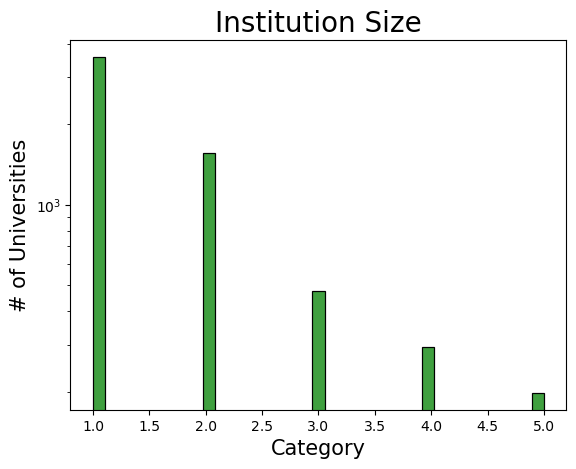

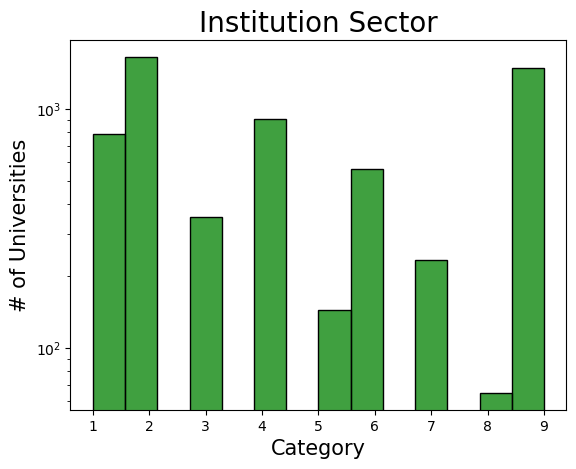

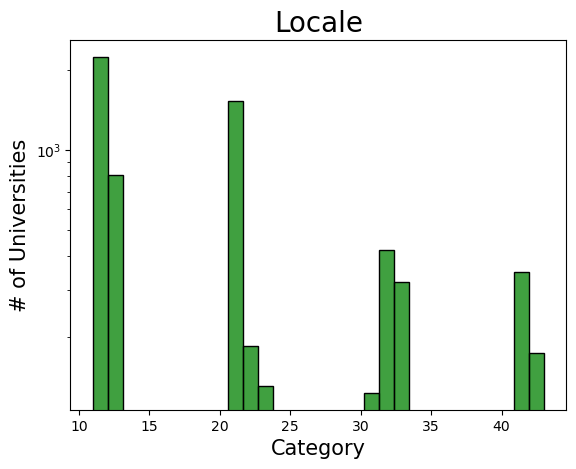

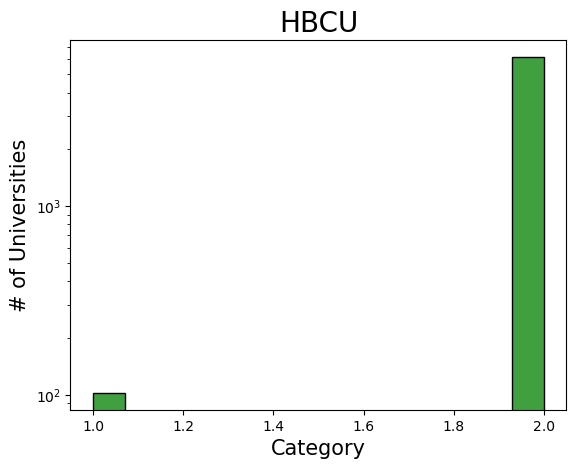

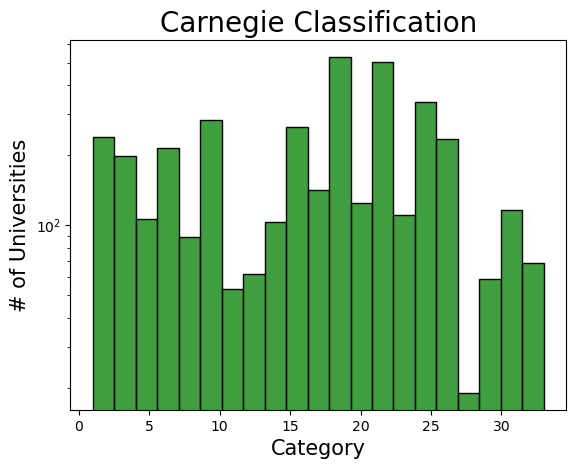

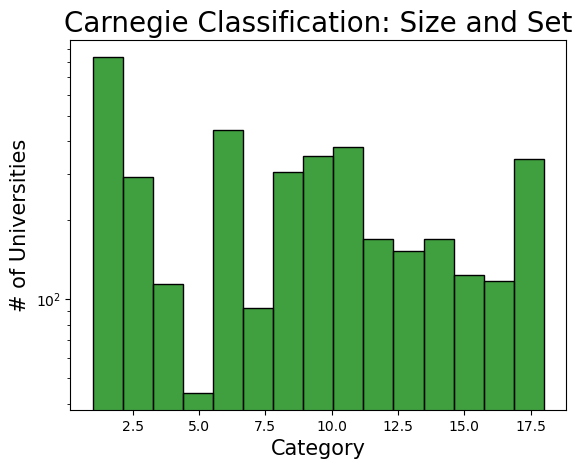

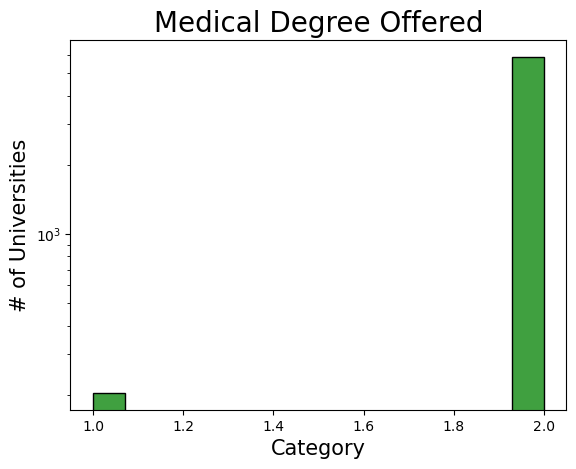

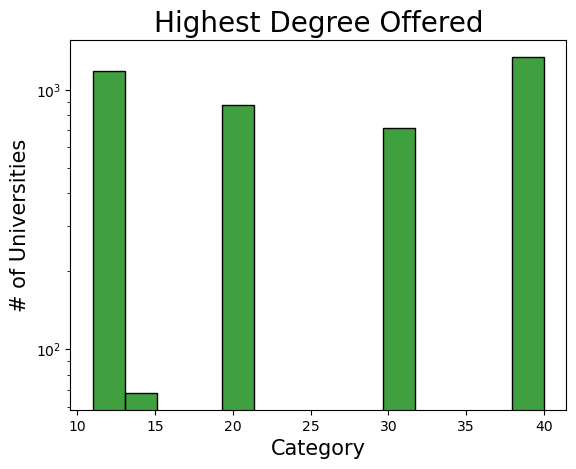

<Figure size 640x480 with 0 Axes>

In [35]:
factors = ['INSTSIZE', 'SECTOR', 'LOCALE', 'HBCU', 'C18BASIC', 'C21SZSET', 'MEDICAL', 'HDEGOFR1']
factor_names = ['Institution Size', 'Institution Sector', 'Locale', 'HBCU', 'Carnegie Classification', 'Carnegie Classification: Size and Set', \
                'Medical Degree Offered', 'Highest Degree Offered']
for i, factor in enumerate(factors):
    bin = len(all_unis[2020][factor].unique())
    all_unis[2020][factor] = all_unis[2020][factor][all_unis[2020][factor] < 70]
    all_unis[2020][factor] = all_unis[2020][factor][all_unis[2020][factor] > 0]
    sns.histplot(data = all_unis[2020][factor], color='green')
    # plt.hist(all_unis[2020][factor], label=factor_names[i])
    plt.title(factor_names[i], fontsize=20)
    plt.yscale('log')
    plt.ylabel('# of Universities', fontsize = 15)
    plt.xlabel('Category', fontsize=15)
    plt.figure()

<Figure size 640x480 with 0 Axes>

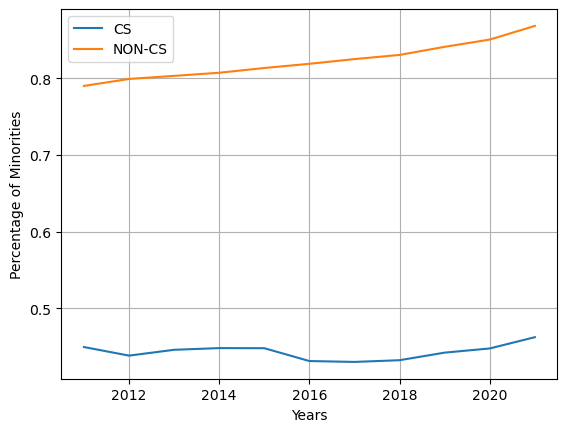

<Figure size 640x480 with 0 Axes>

In [184]:
plt.plot(csPercent['year'], csPercent['minority'], label='CS')
plt.plot(nonCsPercent['year'], nonCsPercent['minority'], label='NON-CS')
plt.ylabel('Percentage of Minorities')
plt.xlabel('Years')
plt.grid()
plt.legend()
plt.figure()

Text(0.5, 1.0, 'CS Prgrams')

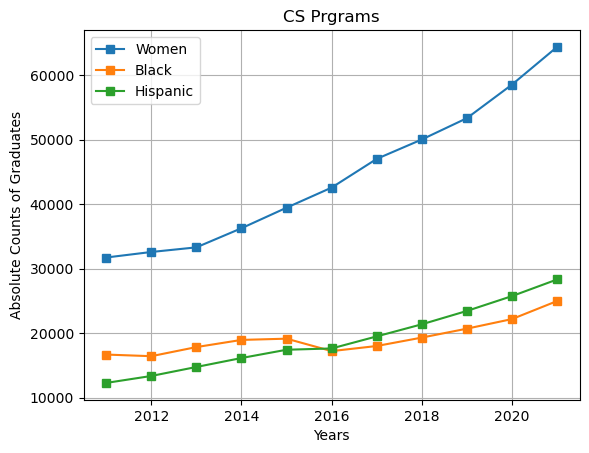

In [37]:
for i, demo in enumerate(demo_names):
    names = ['Women', 'Black', 'Hispanic']
    plt.plot(csTotal['year'], csTotal[demo], label=names[i], marker='s')
    plt.ylabel('Absolute Counts of Graduates')
    plt.xlabel('Years')
    plt.grid()
plt.legend()
plt.title('CS Prgrams')

Text(0.5, 1.0, 'Non-CS Programs')

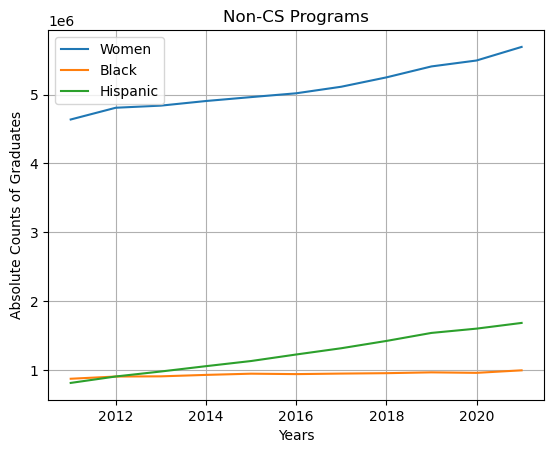

In [192]:
for i, demo in enumerate(demo_names):
    names = ['Women', 'Black', 'Hispanic']
    plt.plot(nonCsTotal['year'], nonCsTotal[demo], label=names[i])
    plt.ylabel('Absolute Counts of Graduates')
    plt.xlabel('Years')
    plt.grid()
plt.legend()
plt.title('Non-CS Programs')

(0.0, 0.6)

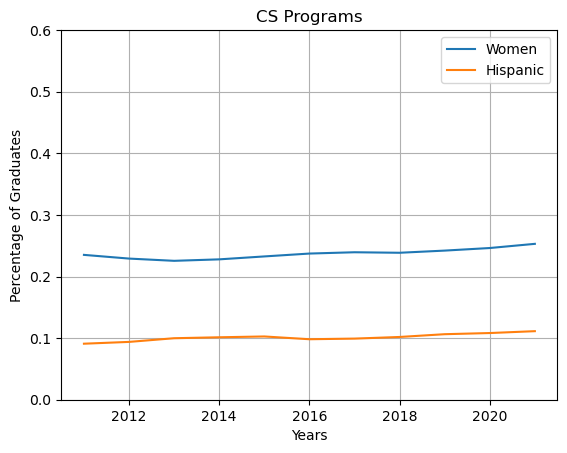

In [197]:
for i, demo in enumerate(demo_names):
    names = ['Women', 'Black', 'Hispanic']
    if demo == 'CBKAAT':
        continue
    plt.plot(csPercent['year'], csPercent[demo], label=names[i])
    plt.ylabel('Percentage of Graduates')
    plt.xlabel('Years')
plt.grid()
plt.legend()
plt.title('CS Programs')
plt.ylim(0, 0.6)

Text(0.5, 1.0, 'Non-CS Programs')

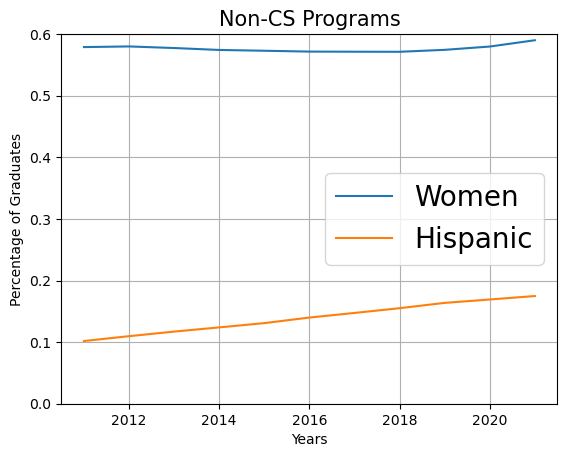

In [203]:
for i, demo in enumerate(demo_names):
    names = ['Women', 'Black', 'Hispanic']
    if demo == 'CBKAAT':
        continue
    plt.plot(nonCsPercent['year'], nonCsPercent[demo], label=names[i])
    plt.ylabel('Percentage of Graduates')
    plt.xlabel('Years')
plt.grid()
plt.legend(fontsize=20)
plt.ylim(0, 0.6)
plt.title('Non-CS Programs', fontsize=15)

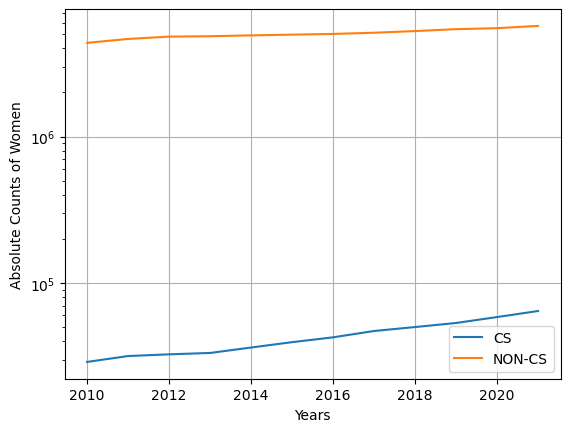

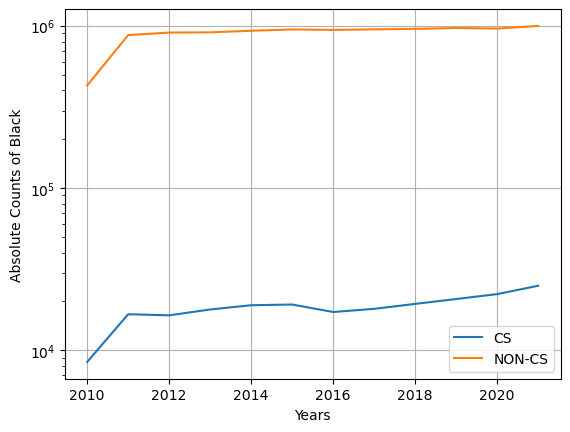

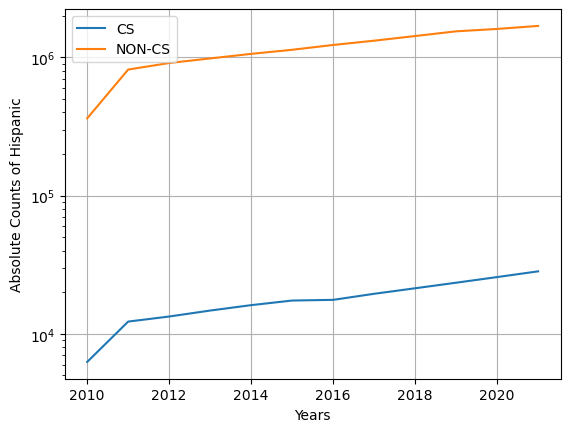

<Figure size 640x480 with 0 Axes>

In [117]:
for i, demo in enumerate(demo_names):
    names = ['Women', 'Black', 'Hispanic']
    plt.plot(csTotalGroup['year'], csTotalGroup[demo], label='CS')
    plt.plot(nonCsTotalGroup['year'], nonCsTotalGroup[demo], label='NON-CS')
    plt.ylabel('Absolute Counts of %s'%names[i])
    plt.xlabel('Years')
    plt.grid()
    plt.yscale('log')
    plt.legend()
    plt.figure()